# Avaliador de Resultados

In [440]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

### Esperados

In [441]:
df_esperados = pd.read_csv('../result/esperados.csv', sep=';')
df_esperados.head()

,QueryNumber,DocNumber,DocVotes
0,1,139,4
1,1,151,4
2,1,166,1
3,1,311,1
4,1,370,2


### Com Stemmer

In [442]:
df_stem = pd.read_csv('../result/resultados-stemmer.csv', sep=';')

df_stem_split = df_stem['ResultList'].str.split(', ', expand=True)

df_stem['DocPosition'] = df_stem_split[0].str[1:]
df_stem['DocNumber'] = df_stem_split[1]
df_stem['ElementDistance'] = df_stem_split[2].str[:-1]

df_stem.drop(columns=['ResultList'], inplace=True)

df_stem.head()

,QueryId,DocPosition,DocNumber,ElementDistance
0,1,1,484,0.2210348059872781
1,1,2,437,0.20071038791325813
2,1,3,957,0.1709966846928236
3,1,4,526,0.166461813609632
4,1,5,827,0.16326113645715498


### Sem Stemmer

In [443]:
df_nostem = pd.read_csv('../result/resultados-nostemmer.csv', sep=';')

df_nostem_split = df_nostem['ResultList'].str.split(', ', expand=True)

df_nostem['DocPosition'] = df_nostem_split[0].str[1:]
df_nostem['DocNumber'] = df_nostem_split[1]
df_nostem['ElementDistance'] = df_nostem_split[2].str[:-1]

df_nostem.drop(columns=['ResultList'], inplace=True)

df_nostem.head()

,QueryId,DocPosition,DocNumber,ElementDistance
0,1,1,437,0.21901474567304474
1,1,2,484,0.20909903368469954
2,1,3,498,0.16591723658932545
3,1,4,526,0.15869120191669298
4,1,5,741,0.14835756463307


## Gráfico de 11 pontos de precisão e recall

In [444]:
def generate_precision_recall(points, result, expected, csv_filename, plot_filename):
    queries_set = set(result['QueryId'].to_list())
    precisions_list = []
    recalls_list = []
    
    for query in queries_set:
        relevant_docs = set(expected[expected['QueryNumber'] == query]['DocNumber'])
        retrieved_docs = result[result['QueryId'] == query]['DocNumber']
        if len(retrieved_docs) == 0:
            continue
        
        precisions = []
        recalls = []
        step = max(1, len(retrieved_docs) // points)
        
        for point in range(step, len(retrieved_docs) + 1, step):
            current_retrieved = set(map(int,retrieved_docs[:point]))
           
            true_positives = len(current_retrieved.intersection(relevant_docs))
        
            precision = true_positives / len(current_retrieved)
            recall = true_positives / len(relevant_docs)
            
            precisions.append(precision)
            recalls.append(recall)
        
        precisions_list.append(precisions)
        recalls_list.append(recalls)
    
    mean_precisions = np.mean([np.pad(p, (0, points - len(p)), 'constant') for p in precisions_list], axis=0)
    mean_recalls = np.mean([np.pad(r, (0, points - len(r)), 'constant') for r in recalls_list], axis=0)
    
    plt.figure(figsize=(4, 3))
    plt.plot(mean_recalls, mean_precisions, marker='o')
    plt.title(f'{points} Pontos Precision-Recall')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.grid(True)
    plt.savefig(plot_filename + '-2.pdf')
    plt.savefig(plot_filename + '-3.png')
    plt.show()
    
    precision_recall_df = pd.DataFrame({'Precision': mean_precisions, 'Recall': mean_recalls})
    precision_recall_df.to_csv(csv_filename, sep=';', index=False)

### Com Stemmer

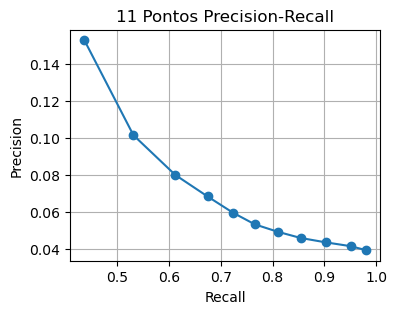

In [445]:
generate_precision_recall(11, df_stem, df_esperados, '../avalia/11pontos-stemmer-1.csv', '../avalia/11pontos-stemmer')

### Sem Stemmer

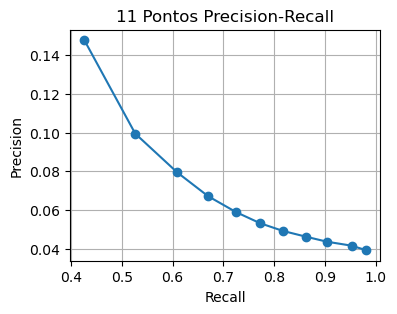

In [446]:
generate_precision_recall(11, df_nostem, df_esperados, '../avalia/11pontos-nostemmer-1.csv', '../avalia/11pontos-nostemmer')

## F1

**OBS**: Considere apenas os 10 primeiros documentos recuperados no ranking

In [447]:
def calculate_f1(result, expected):
    queries_set = set(result['QueryId'].to_list())

    precisions_dict = {}
    recalls_dict = {}

    for query in queries_set:
        relevant_docs = set(expected[expected['QueryNumber'] == query]['DocNumber'].to_list())

        current_retrieveds = set(map(int,result[result['QueryId'] == query]['DocNumber'].to_list()[:10]))
    
        true_positives = len(relevant_docs.intersection(current_retrieveds))

        precision = true_positives / len(current_retrieveds) if len(current_retrieveds) > 0 else 0
        recall = true_positives / len(relevant_docs) if len(relevant_docs) > 0 else 0

        precisions_dict[query] = precision
        recalls_dict[query] = recall


    precisions_list = np.array(list(precisions_dict.values()))
    recalls_list = np.array(list(recalls_dict.values()))

    mean_precision = np.mean(precisions_list)
    mean_recall = np.mean(recalls_list)

    if (mean_precision + mean_recall == 0):
        return 0

    f1_score = (2 * mean_precision * mean_recall) / (mean_precision + mean_recall)
    return f1_score

### (Com Stemmer, Sem Stemmer)

In [448]:
calculate_f1(df_stem, df_esperados), calculate_f1(df_nostem, df_esperados)

(0.22264317729630048, 0.2151513849757518)

## Precision@N

In [449]:

def mean_precision_at_n(n, result, expected):
    queries_set = set(result['QueryId'].to_list())
    precisions = []
    for query in queries_set:
        relevant_docs = expected[expected['QueryNumber'] == query]['DocNumber'].to_list()
        current_retrieveds = list(map(int,result[result['QueryId'] == query]['DocNumber'].to_list()[:n]))

        true_positives = len(set(relevant_docs).intersection(current_retrieveds))

        precision = true_positives / n
        precisions.append(precision)
    
    mean_precisions = np.mean(precisions)
    return mean_precisions

### Precision@5

##### Com Stemmer x Sem Stemmer

In [450]:
mean_precision_at_n(5, df_stem, df_esperados), mean_precision_at_n(5, df_nostem, df_esperados)

(0.5313131313131313, 0.49494949494949503)

##### Com Stemmer x Sem Stemmer

### Precision@10

In [451]:
mean_precision_at_n(10, df_stem, df_esperados), mean_precision_at_n(10, df_nostem, df_esperados)

(0.41919191919191906, 0.4151515151515151)

## Histograma de R-Precision (comparativo)

In [452]:

def calculate_r_precision(n, retrieved_docs, relevant_docs):
    true_positives = len(set(relevant_docs).intersection(retrieved_docs[:n]))
    return true_positives / n

def get_relevant_docs(expected, query):
    return expected[expected['QueryNumber'] == query]['DocNumber'].to_list()


def get_retrieved_docs(result, query, k):
    return list(map(int,result[result['QueryId'] == query]['DocNumber'].to_list()[:k]))

def calculate_all_r_precisions(result, expected, k=10):
    r_precisions = []
    queries_set = set(result['QueryId'].to_list())

    for query in queries_set:
        relevant_docs = get_relevant_docs(expected, query)
        retrieved_docs = get_retrieved_docs(result, query, k)

        r_precision = calculate_r_precision(k, retrieved_docs, relevant_docs)
        r_precisions.append(r_precision)
    
    return queries_set, r_precisions


def compare_r_precisions(result_nostem, result_stem, expected, csv_filename, plot_filename):
    queries_set, r_precisions_nostem = calculate_all_r_precisions(result_nostem, expected)
    _, r_precisions_stem = calculate_all_r_precisions(result_stem, expected)
    comparative = np.array(r_precisions_stem) - np.array(r_precisions_nostem)
    comparative_r_precisions_df = pd.DataFrame({'r_precision': comparative, 'query': list(queries_set)})

    comparative_r_precisions_df.to_csv(csv_filename, sep=";", index=False)
    
    plt.bar(list(queries_set), comparative)
    plt.title("Comparando R-Precision (Stemmer - NOStemmer)")
    plt.xlabel("Query")
    plt.ylabel("(R-Precision-Stemmer - R-Precision-NOStemmer)")
    plt.savefig(plot_filename + '-2.pdf')
    plt.savefig(plot_filename + '-3.png')
    plt.show()

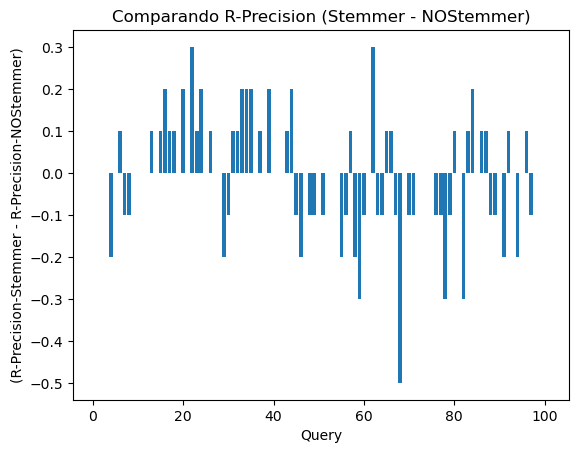

In [453]:
compare_r_precisions(df_stem, df_nostem, df_esperados, "../avalia/r-precision-comparative-1.csv", "../avalia/r-precision-comparative")

## MAP

In [454]:
mean_precision_at_n(5, df_stem, df_esperados), mean_precision_at_n(5, df_nostem, df_esperados)

(0.5313131313131313, 0.49494949494949503)

In [460]:
def calculate_precision_at_k(retrieved_docs, relevant_docs, k):
    relevant_at_k = set(retrieved_docs[:k]).intersection(relevant_docs)
    return len(relevant_at_k) / k

def calculate_map(result, excepted):
    queries_set = set(result['QueryId'].to_list())
    average_precisions = []


    for query in queries_set:
        relevant_docs = set(excepted[excepted['QueryNumber'] == query]['DocNumber'])
        retrieved_docs = list(map(int,result[result['QueryId'] == query]['DocNumber'].tolist()))

        precisions = [
            calculate_precision_at_k(retrieved_docs, relevant_docs, k + 1)
            for k, doc in enumerate(retrieved_docs)
            if doc in relevant_docs
        ]
                
        if precisions:
            average_precisions.append(np.mean(precisions))
        else:
            average_precisions.append(0.0)

    return np.mean(average_precisions)

### Com Stemmer x Sem Stemmer

In [461]:
calculate_map(df_stem, df_esperados), calculate_map(df_nostem, df_esperados)

(0.2529816637653684, 0.25029008690624566)

## MRR

In [474]:
def calculate_mrr(result, exptected):
    queries_set = set(result['QueryId'].to_list())
    reciprocal_ranks = []


    for query in queries_set:
        relevant_docs = set(exptected[exptected['QueryNumber'] == query]['DocNumber'])
        retrieved_docs = list(map(int, result[result['QueryId'] == query]['DocNumber'][:10]))

        reciprocal_rank = next((1 / (idx + 1) for idx, doc in enumerate(retrieved_docs) if doc in relevant_docs), 0)

        reciprocal_ranks.append(reciprocal_rank)
    
    return np.mean(reciprocal_ranks)

### Com Stemmer x Sem Stemmer

In [475]:
calculate_mrr(df_stem, df_esperados), calculate_mrr(df_nostem, df_esperados)

(0.8111111111111112, 0.8069143819143819)

## Discounted Cumulative Gain (médio)

In [487]:
def dcg_at_k(retrieved_docs, relevant_docs, scores, k=10):
    dcg = 0.0
    for idx in range(min(k, len(retrieved_docs))):
        if retrieved_docs[idx] in relevant_docs:
            rel_idx = relevant_docs.index(retrieved_docs[idx])
            score = scores[rel_idx]
            dcg += score if idx == 0 else score / np.log2(idx + 1)
    return dcg

def mean_discounted_cumulative_gain(result, expected):
    queries_set = set(result['QueryId'].to_list())
    discounted_cumulative_gains = []

    for query in queries_set:
        relevant_docs = expected[expected['QueryNumber'] == query]['DocNumber'].tolist()
        scores = expected[expected['QueryNumber'] == query]['DocVotes'].tolist()
        retrieved_docs = list(map(int,result[result['QueryId'] == query]['DocNumber'].tolist()[:10]))

        dcg = dcg_at_k(retrieved_docs, relevant_docs, scores)
        discounted_cumulative_gains.append(dcg)

    mean_dcg = np.mean(discounted_cumulative_gains)
    return mean_dcg

[4.682207769667484,
 0.7317065537373743,
 6.879926201393852,
 6.0,
 9.958848488995491,
 5.630929753571458,
 6.068621561324067,
 0.3010299956639812,
 6.0,
 9.055695982660485,
 10.266254723355022,
 0.0,
 6.0,
 7.2227062322935724,
 14.118929068433802,
 5.879926201393852,
 6.693555406426718,
 10.198818174621453,
 0.0,
 15.526129158733351,
 13.154648767857289,
 4.653803607346147,
 0.0,
 3.0,
 9.83739803646987,
 12.571130243223998,
 8.0,
 7.213259534727185,
 6.2618595071429155,
 2.8333333333333335,
 12.65466598152901,
 8.0,
 15.997956458173494,
 13.94854776271792,
 4.430676558073393,
 3.0,
 17.101443690209862,
 0.3010299956639812,
 8.696980113652533,
 1.5909727898904664,
 6.829292324989418,
 17.835160096399367,
 7.2879951448602505,
 16.82929232498942,
 9.870877047725932,
 11.332989750366913,
 1.3333333333333333,
 2.0789134194015944,
 17.212644534793306,
 14.246425246579403,
 15.768110356876528,
 4.0,
 10.563648408695569,
 16.109387248044904,
 2.5814533609730557,
 4.099267181450586,
 8.849768